<a href="https://colab.research.google.com/github/PranitaAnnaldas/A-predictive-model-to-assess-the-environmental-impact-of-urban-expansion/blob/master/ml/Rainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Load and preprocess data
data = pd.read_csv("rainfall_data.csv")
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%d-%m-%Y %H:%M")
data['Date'] = data['Datetime'].dt.date

# Daily aggregated data
daily_data = data.groupby('Date').agg(
    min_rainfall=('min_rainfall', 'min'),
    max_rainfall=('max_rainfall', 'max'),
    rained=('rained', 'max')
).reset_index()

# Add date features
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data['DayOfYear'] = daily_data['Date'].dt.dayofyear
daily_data['Month'] = daily_data['Date'].dt.month
daily_data['DayOfWeek'] = daily_data['Date'].dt.dayofweek

# Features
features = ['DayOfYear', 'Month', 'DayOfWeek']

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Regressor': SVR()
}

# -------------------------------
# 🔹 Train for min_rainfall
# -------------------------------
X_min = daily_data[features]
y_min = daily_data['min_rainfall']
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size=0.2, random_state=42)

results_min = {}
trained_min_models = {}
for name, model in models.items():
    model.fit(X_train_min, y_train_min)
    preds = model.predict(X_test_min)
    mse = mean_squared_error(y_test_min, preds)
    results_min[name] = mse
    trained_min_models[name] = model
    print(f"Min Rainfall - {name}: MSE = {mse:.4f}")

best_model_min_name = min(results_min, key=results_min.get)
best_model_min = trained_min_models[best_model_min_name]
print(f"\n✅ Best model for Min Rainfall: {best_model_min_name}")

# Predict for 2031
date_range = pd.date_range(start="2031-01-01", end="2031-12-31")
future_data = pd.DataFrame({
    'Date': date_range,
    'DayOfYear': date_range.dayofyear,
    'Month': date_range.month,
    'DayOfWeek': date_range.dayofweek
})

future_data[f'Predicted_Min_Rainfall ({best_model_min_name})'] = np.clip(
    best_model_min.predict(future_data[features]), 0, None
)

# -------------------------------
# 🔹 Train for max_rainfall
# -------------------------------
X_max = daily_data[features]
y_max = daily_data['max_rainfall']
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, y_max, test_size=0.2, random_state=42)

results_max = {}
trained_max_models = {}
for name, model in models.items():
    model.fit(X_train_max, y_train_max)
    preds = model.predict(X_test_max)
    mse = mean_squared_error(y_test_max, preds)
    results_max[name] = mse
    trained_max_models[name] = model
    print(f"Max Rainfall - {name}: MSE = {mse:.4f}")

best_model_max_name = min(results_max, key=results_max.get)
best_model_max = trained_max_models[best_model_max_name]
print(f"\n✅ Best model for Max Rainfall: {best_model_max_name}")

# Predict for 2031
future_data[f'Predicted_Max_Rainfall ({best_model_max_name})'] = np.clip(
    best_model_max.predict(future_data[features]), 0, None
)

# -------------------------------
# 🔹 Derive Rained
# -------------------------------
min_col = f'Predicted_Min_Rainfall ({best_model_min_name})'
max_col = f'Predicted_Max_Rainfall ({best_model_max_name})'
future_data['Predicted_Rained'] = (
    (future_data[min_col] > 0.1) | (future_data[max_col] > 0.1)
).astype(int)

# -------------------------------
# 🔹 Save to CSV
# -------------------------------
final_df = future_data[['Date', min_col, max_col, 'Predicted_Rained']]
final_df.to_csv("rainfall_predictions_2031.csv", index=False)

print("\n📁 Rainfall predictions saved to 'rainfall_predictions_2031.csv'")


Min Rainfall - Linear Regression: MSE = 0.0011
Min Rainfall - Decision Tree: MSE = 0.0015
Min Rainfall - Random Forest: MSE = 0.0012
Min Rainfall - Gradient Boosting: MSE = 0.0008
Min Rainfall - AdaBoost: MSE = 0.0008
Min Rainfall - XGBoost: MSE = 0.0010
Min Rainfall - LightGBM: MSE = 0.0008
Min Rainfall - K-Nearest Neighbors: MSE = 0.0009
Min Rainfall - Support Vector Regressor: MSE = 0.0032

✅ Best model for Min Rainfall: Gradient Boosting
Max Rainfall - Linear Regression: MSE = 0.0766
Max Rainfall - Decision Tree: MSE = 0.0512
Max Rainfall - Random Forest: MSE = 0.0390
Max Rainfall - Gradient Boosting: MSE = 0.0283
Max Rainfall - AdaBoost: MSE = 0.0309
Max Rainfall - XGBoost: MSE = 0.0347
Max Rainfall - LightGBM: MSE = 0.0299
Max Rainfall - K-Nearest Neighbors: MSE = 0.0335
Max Rainfall - Support Vector Regressor: MSE = 0.0395

✅ Best model for Max Rainfall: Gradient Boosting

📁 Rainfall predictions saved to 'rainfall_predictions_2031.csv'


In [ ]:
!pip uninstall -y numpy pmdarima
!pip install numpy==1.23.5
!pip install pmdarima==1.8.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 

  Using cached pmdarima-1.8.5.tar.gz (639 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pmdarima
  Running setup.py clean for pmdarima
Failed to build pmdarima
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pmdarima)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

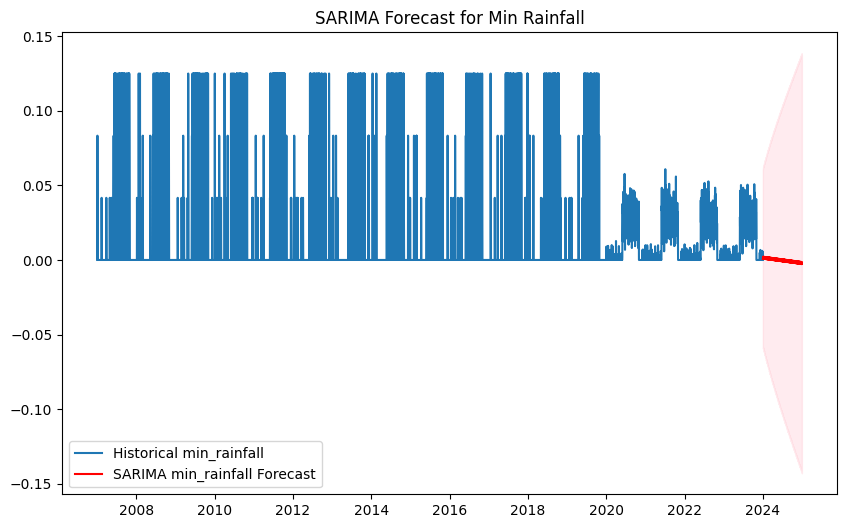

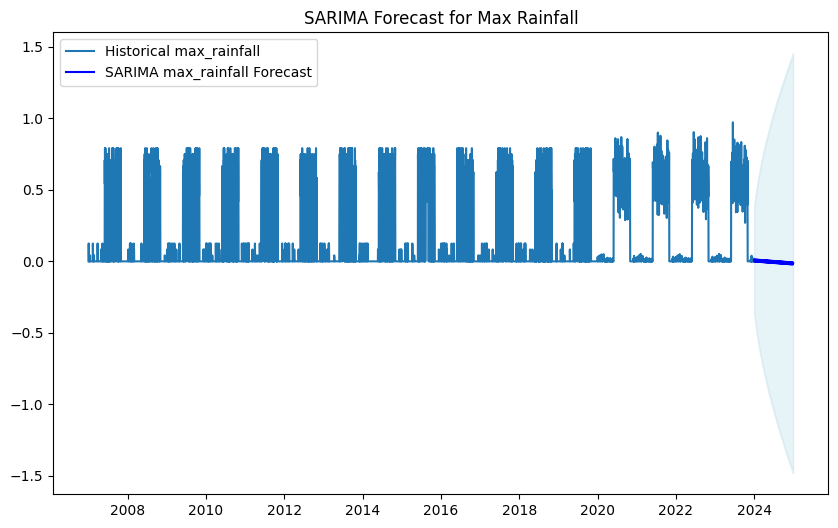

SARIMA MSE for Min Rainfall: 0.00037571291039572294
SARIMA RMSE for Min Rainfall: 0.01938331525812143
SARIMA MSE for Max Rainfall: 0.15722899035162505
SARIMA RMSE for Max Rainfall: 0.3965211095914378


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the data
data = pd.read_csv('rainfall_data.csv')  # Replace with your data path
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Aggregate the data to daily
data['Date'] = data['Datetime'].dt.date
daily_data = data.groupby('Date').agg({'min_rainfall': 'min', 'max_rainfall': 'max', 'rained': 'max'}).reset_index()

# Set the 'Date' column as index
daily_data.set_index('Date', inplace=True)

# Train SARIMA model for min_rainfall
sarima_model_min = SARIMAX(daily_data['min_rainfall'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Seasonal order (p,d,q,s)
sarima_fit_min = sarima_model_min.fit(disp=False)

# Predicting the future for min_rainfall (for example, predicting the next 365 days)
forecast_sarima_min = sarima_fit_min.get_forecast(steps=365)
forecast_sarima_min_ci = forecast_sarima_min.conf_int()

# Train SARIMA model for max_rainfall
sarima_model_max = SARIMAX(daily_data['max_rainfall'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))  # Seasonal order (p,d,q,s)
sarima_fit_max = sarima_model_max.fit(disp=False)

# Predicting the future for max_rainfall (for example, predicting the next 365 days)
forecast_sarima_max = sarima_fit_max.get_forecast(steps=365)
forecast_sarima_max_ci = forecast_sarima_max.conf_int()

# Plot the results for min_rainfall
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data['min_rainfall'], label='Historical min_rainfall')
plt.plot(forecast_sarima_min.predicted_mean.index, forecast_sarima_min.predicted_mean, label='SARIMA min_rainfall Forecast', color='red')
plt.fill_between(forecast_sarima_min_ci.index, forecast_sarima_min_ci.iloc[:, 0], forecast_sarima_min_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecast for Min Rainfall')
plt.show()

# Plot the results for max_rainfall
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data['max_rainfall'], label='Historical max_rainfall')
plt.plot(forecast_sarima_max.predicted_mean.index, forecast_sarima_max.predicted_mean, label='SARIMA max_rainfall Forecast', color='blue')
plt.fill_between(forecast_sarima_max_ci.index, forecast_sarima_max_ci.iloc[:, 0], forecast_sarima_max_ci.iloc[:, 1], color='lightblue', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecast for Max Rainfall')
plt.show()

# Evaluate the SARIMA model for min_rainfall
y_true_min = daily_data['min_rainfall'][-365:]  # Replace with actual test data if available
y_pred_min = forecast_sarima_min.predicted_mean
mse_sarima_min = mean_squared_error(y_true_min, y_pred_min)
rmse_sarima_min = sqrt(mse_sarima_min)
print(f'SARIMA MSE for Min Rainfall: {mse_sarima_min}')
print(f'SARIMA RMSE for Min Rainfall: {rmse_sarima_min}')

# Evaluate the SARIMA model for max_rainfall
y_true_max = daily_data['max_rainfall'][-365:]  # Replace with actual test data if available
y_pred_max = forecast_sarima_max.predicted_mean
mse_sarima_max = mean_squared_error(y_true_max, y_pred_max)
rmse_sarima_max = sqrt(mse_sarima_max)
print(f'SARIMA MSE for Max Rainfall: {mse_sarima_max}')
print(f'SARIMA RMSE for Max Rainfall: {rmse_sarima_max}')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xnsvpdr/8a200yyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xnsvpdr/4cdffx0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13977', 'data', 'file=/tmp/tmp5xnsvpdr/8a200yyx.json', 'init=/tmp/tmp5xnsvpdr/4cdffx0y.json', 'output', 'file=/tmp/tmp5xnsvpdr/prophet_modeld6j_4s03/prophet_model-20250415091617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE) for min_rainfall: 0.0008605348604750389


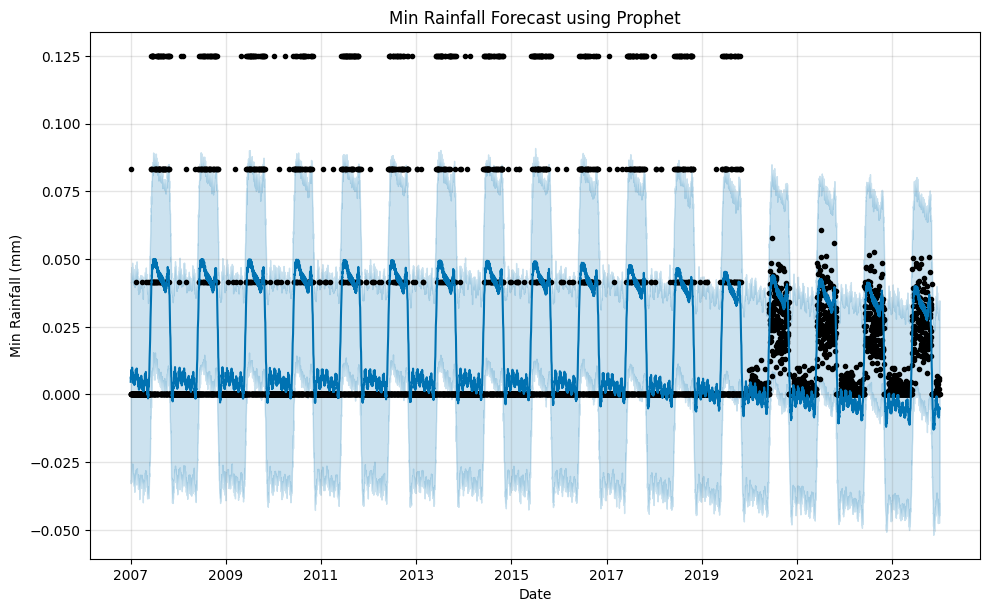

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xnsvpdr/ffg9p1q9.json


             ds      yhat  yhat_lower  yhat_upper
6204 2023-12-27 -0.007963   -0.047413    0.032638
6205 2023-12-28 -0.006316   -0.042696    0.031427
6206 2023-12-29 -0.004685   -0.040085    0.034743
6207 2023-12-30 -0.005338   -0.041693    0.033563
6208 2023-12-31 -0.005390   -0.044503    0.030948


DEBUG:cmdstanpy:input tempfile: /tmp/tmp5xnsvpdr/yvohf6hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76319', 'data', 'file=/tmp/tmp5xnsvpdr/ffg9p1q9.json', 'init=/tmp/tmp5xnsvpdr/yvohf6hd.json', 'output', 'file=/tmp/tmp5xnsvpdr/prophet_modeltn9avsbm/prophet_model-20250415091620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE) for max_rainfall: 0.03227775753786361


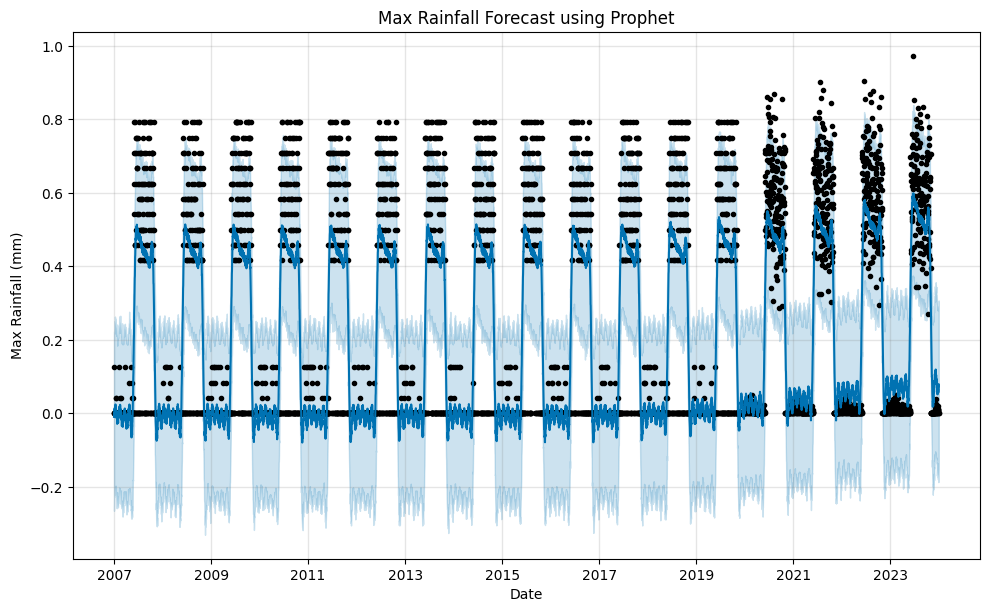

             ds      yhat  yhat_lower  yhat_upper
6204 2023-12-27  0.068203   -0.159974    0.297030
6205 2023-12-28  0.056833   -0.186863    0.280111
6206 2023-12-29  0.079253   -0.135593    0.306636
6207 2023-12-30  0.079850   -0.154637    0.303602
6208 2023-12-31  0.073354   -0.161225    0.306463


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load and prepare the dataset
data = pd.read_csv('rainfall_data.csv')  # Replace with your data path

# Ensure 'Datetime' column is in datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Aggregate the data to daily level (if required)
data['Date'] = data['Datetime'].dt.date
daily_data = data.groupby('Date').agg({'min_rainfall': 'min', 'max_rainfall': 'max'}).reset_index()

# Step 2: Prepare the data for Prophet (for min_rainfall)
# Prophet requires a 'ds' column (for dates) and a 'y' column (for the values to predict)
prophet_data_min = daily_data.rename(columns={'Date': 'ds', 'min_rainfall': 'y'})  # Rename columns for Prophet

# Step 3: Initialize the Prophet model for min_rainfall
prophet_model_min = Prophet()

# Step 4: Fit the model for min_rainfall
prophet_model_min.fit(prophet_data_min)

# Step 5: Make predictions for min_rainfall on historical data to calculate MSE
forecast_min = prophet_model_min.predict(prophet_data_min)

# Step 6: Calculate MSE for min_rainfall forecast
mse_min = mean_squared_error(prophet_data_min['y'], forecast_min['yhat'])
print(f"Mean Squared Error (MSE) for min_rainfall: {mse_min}")

# Step 7: Plot the results for min_rainfall
prophet_model_min.plot(forecast_min)
plt.title('Min Rainfall Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Min Rainfall (mm)')
plt.show()

# Optionally, display the forecasted values (including uncertainty intervals) for min_rainfall
print(forecast_min[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Step 8: Prepare the data for Prophet (for max_rainfall)
prophet_data_max = daily_data.rename(columns={'Date': 'ds', 'max_rainfall': 'y'})  # Rename columns for Prophet

# Step 9: Initialize the Prophet model for max_rainfall
prophet_model_max = Prophet()

# Step 10: Fit the model for max_rainfall
prophet_model_max.fit(prophet_data_max)

# Step 11: Make predictions for max_rainfall on historical data to calculate MSE
forecast_max = prophet_model_max.predict(prophet_data_max)

# Step 12: Calculate MSE for max_rainfall forecast
mse_max = mean_squared_error(prophet_data_max['y'], forecast_max['yhat'])
print(f"Mean Squared Error (MSE) for max_rainfall: {mse_max}")

# Step 13: Plot the results for max_rainfall
prophet_model_max.plot(forecast_max)
plt.title('Max Rainfall Forecast using Prophet')
plt.xlabel('Date')
plt.ylabel('Max Rainfall (mm)')
plt.show()

# Optionally, display the forecasted values (including uncertainty intervals) for max_rainfall
print(forecast_max[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


In [ ]:
pip install --upgrade numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 40.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [ ]:
pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - loss: 0.0816
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0748
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0764
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0731
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0733
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0751
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0742
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0730
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0747
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0732
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Min Rainfall LSTM MSE: 0.04919967015672486


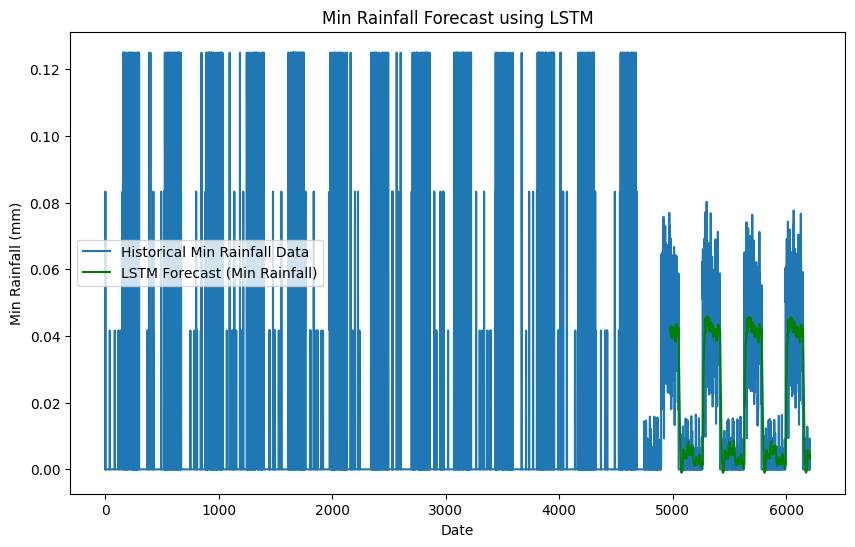

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0920
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0647
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0684
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0648
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0656
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0641
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 0.0626
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0611
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0585
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0612
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Max Rainfall LSTM MSE: 0.018447195506621054


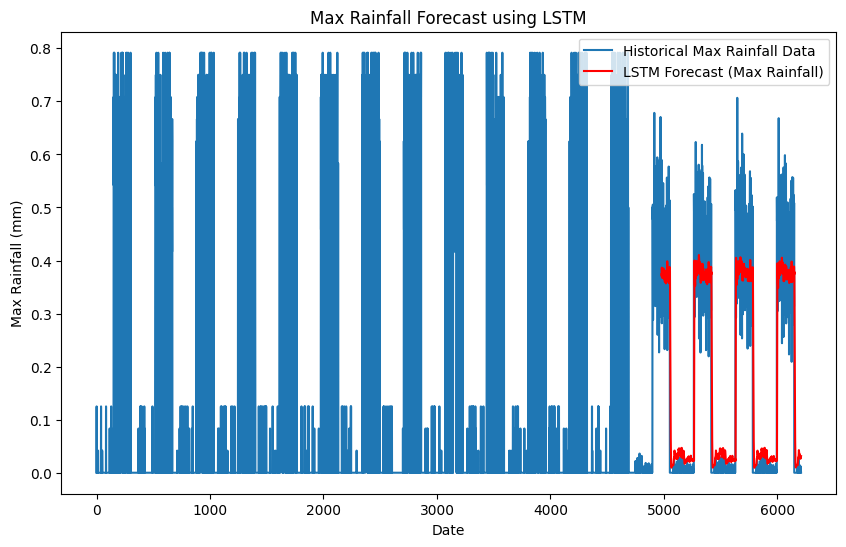

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Load and prepare the dataset
data = pd.read_csv('rainfall_data.csv')  # Replace with your data path

# Ensure 'Datetime' column is in datetime format
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')

# Aggregate the data to daily level (if required)
data['Date'] = data['Datetime'].dt.date
daily_data = data.groupby('Date').agg({'min_rainfall': 'mean', 'max_rainfall': 'mean'}).reset_index()

# Step 2: Prepare the data for LSTM (for min_rainfall)
scaler_min = MinMaxScaler(feature_range=(0, 1))
data_scaled_min = scaler_min.fit_transform(daily_data[['min_rainfall']])

# Create sequences for LSTM (X, y)
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Time steps for LSTM input
X_min, y_min = create_sequences(data_scaled_min, time_step)

# Reshape X for LSTM (samples, time_steps, features)
X_min = X_min.reshape(X_min.shape[0], X_min.shape[1], 1)

# Split the data into training and test sets (80% training, 20% testing)
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size=0.2, shuffle=False)

# Build the LSTM model for min_rainfall
model_min = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train_min.shape[1], 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

# Compile and train the model for min_rainfall
model_min.compile(optimizer='adam', loss='mean_squared_error')
model_min.fit(X_train_min, y_train_min, epochs=10, batch_size=64)

# Predict using the LSTM model for min_rainfall
predictions_min = model_min.predict(X_test_min)

# Inverse transform the predictions
predictions_min_rescaled = scaler_min.inverse_transform(predictions_min)

# Evaluate the model for min_rainfall
mse_min = mean_squared_error(y_test_min, predictions_min_rescaled)
print(f'Min Rainfall LSTM MSE: {mse_min}')

# Step 3: Plot predictions for min_rainfall
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(daily_data['min_rainfall'])), daily_data['min_rainfall'], label='Historical Min Rainfall Data')
plt.plot(np.arange(len(daily_data['min_rainfall']) - len(predictions_min_rescaled), len(daily_data['min_rainfall'])), predictions_min_rescaled, label='LSTM Forecast (Min Rainfall)', color='green')
plt.legend()
plt.title('Min Rainfall Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Min Rainfall (mm)')
plt.show()

# Step 4: Prepare the data for LSTM (for max_rainfall)
scaler_max = MinMaxScaler(feature_range=(0, 1))
data_scaled_max = scaler_max.fit_transform(daily_data[['max_rainfall']])

# Create sequences for LSTM (X, y)
X_max, y_max = create_sequences(data_scaled_max, time_step)

# Reshape X for LSTM (samples, time_steps, features)
X_max = X_max.reshape(X_max.shape[0], X_max.shape[1], 1)

# Split the data into training and test sets (80% training, 20% testing)
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, y_max, test_size=0.2, shuffle=False)

# Build the LSTM model for max_rainfall
model_max = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train_max.shape[1], 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

# Compile and train the model for max_rainfall
model_max.compile(optimizer='adam', loss='mean_squared_error')
model_max.fit(X_train_max, y_train_max, epochs=10, batch_size=64)

# Predict using the LSTM model for max_rainfall
predictions_max = model_max.predict(X_test_max)

# Inverse transform the predictions
predictions_max_rescaled = scaler_max.inverse_transform(predictions_max)

# Evaluate the model for max_rainfall
mse_max = mean_squared_error(y_test_max, predictions_max_rescaled)
print(f'Max Rainfall LSTM MSE: {mse_max}')

# Step 5: Plot predictions for max_rainfall
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(daily_data['max_rainfall'])), daily_data['max_rainfall'], label='Historical Max Rainfall Data')
plt.plot(np.arange(len(daily_data['max_rainfall']) - len(predictions_max_rescaled), len(daily_data['max_rainfall'])), predictions_max_rescaled, label='LSTM Forecast (Max Rainfall)', color='red')
plt.legend()
plt.title('Max Rainfall Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Max Rainfall (mm)')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Step 1: Load the data for future forecasting dates
forecast_dates = pd.date_range(start='2024-01-01', end='2031-12-31', freq='D')

# Step 2: Use LSTM for Min Rainfall prediction
# Preprocess the data for min_rainfall
scaler_min = MinMaxScaler(feature_range=(0, 1))
scaled_data_min_rainfall = scaler_min.fit_transform(daily_data[['min_rainfall']])

# Create sequences
def create_sequences(data, time_step=60):
    X = []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
    return np.array(X)

X_min_rainfall = create_sequences(scaled_data_min_rainfall)
X_min_rainfall = X_min_rainfall.reshape(X_min_rainfall.shape[0], X_min_rainfall.shape[1], 1)

# Predict using LSTM model for min_rainfall
lstm_predictions_min_rainfall = model_min.predict(X_min_rainfall[-len(forecast_dates):])
predicted_min_rainfall = scaler_min.inverse_transform(lstm_predictions_min_rainfall)

# Ensure no negative values
predicted_min_rainfall = np.maximum(predicted_min_rainfall, 0)

# Step 3: Use LSTM for Max Rainfall prediction
scaler_max = MinMaxScaler(feature_range=(0, 1))
scaled_data_max_rainfall = scaler_max.fit_transform(daily_data[['max_rainfall']])

X_max_rainfall = create_sequences(scaled_data_max_rainfall)
X_max_rainfall = X_max_rainfall.reshape(X_max_rainfall.shape[0], X_max_rainfall.shape[1], 1)

lstm_predictions_max_rainfall = model_max.predict(X_max_rainfall[-len(forecast_dates):])
predicted_max_rainfall = scaler_max.inverse_transform(lstm_predictions_max_rainfall)

# Step 4: Create the final predictions DataFrame
predictions_df = pd.DataFrame({
    'Date': forecast_dates,
    'min_rainfall': predicted_min_rainfall.flatten(),
    'max_rainfall': predicted_max_rainfall.flatten()
})

# Step 5: Calculate 'rained' based on Max Rainfall
threshold = 0.2
predictions_df['rained'] = predictions_df['max_rainfall'].apply(lambda x: 1 if x > threshold else 0)

# Step 6: Display or save the results
print(predictions_df)
predictions_df.to_csv('rainfall_predictions_2024_2031.csv', index=False)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
           Date  min_rainfall  max_rainfall  rained
0    2024-01-01      0.001278      0.017752       0
1    2024-01-02      0.000905      0.017983       0
2    2024-01-03      0.000592      0.018194       0
3    2024-01-04      0.000335      0.018380       0
4    2024-01-05      0.000131      0.055306       0
...         ...           ...           ...     ...
2917 2031-12-27      0.003189      0.026721       0
2918 2031-12-28      0.003632      0.027835       0
2919 2031-12-29      0.003524      0.029193       0
2920 2031-12-30      0.003498      0.029615       0
2921 2031-12-31      0.004198      0.031287       0

[2922 rows x 4 columns]
